In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchmetrics.classification import ConfusionMatrix
import torch.optim as optim
from PIL import Image
import numpy as np
import os
import time
from tqdm import tqdm
import warnings
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 500)

In [3]:
df = pd.read_csv('pain_dataset_label.csv')
df.head()

,image_path,Pain Intensity,Pain Label
0,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff253.png,0.0,no pain
1,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff035.png,0.0,no pain
2,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff034.png,0.0,no pain
3,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff252.png,0.0,no pain
4,Pain_Dataset_Images/064-ak064/ak064t1aaaff/ak064t1aaaff380.png,0.0,no pain


In [4]:
df['Pain Intensity'].value_counts()

Pain Intensity
0.0     40029
1.0      2909
2.0      2351
3.0      1412
4.0       802
6.0       270
5.0       242
8.0        79
11.0       76
10.0       67
7.0        53
12.0       48
9.0        32
13.0       22
15.0        5
14.0        1
Name: count, dtype: int64

In [5]:
df['subject_id'] =  df['image_path'].str.split('/').str[1]
df['sequence_id'] = df['image_path'].str.split('/').str[2]
df['sequence_no'] =  df['image_path'].str.split('/').str[3].str[-7:-4]

In [6]:
def categorize_pain(intensity):
    if intensity == 0.0:
        return 0
    elif 1.0 <= intensity <= 2.0:
        return 1
    elif 3.0 <= intensity <= 6.0:
        return 2
    else:
        return 3

# Apply the function to categorize pain intensity
df['Category'] = df['Pain Intensity'].apply(categorize_pain)

In [7]:
df['Category'].value_counts()

Category
0    40029
1     5260
2     2726
3      383
Name: count, dtype: int64

In [9]:
temp = pd.DataFrame(df.groupby(['subject_id', 'Pain Intensity'])['Pain Intensity'].count()).rename(columns={'Pain Intensity': 'Count'}).reset_index()

In [48]:
# this individual has only 0 as pain intensity, which was biasing out model so removed it.
all_individual = df['subject_id'].unique().tolist()
all_individual = [i for i in all_individual if i != "101-mg101"]
len(all_individual)

24

In [16]:

print("Total number of individuals:", len(all_individual))

train_list, val_list = train_test_split(all_individual, test_size=0.20, random_state=42)
val_list, test_list = train_test_split(val_list, test_size=0.20, random_state=42)

print("Number of individuals in the training set:", len(train_list))
print("Number of individuals in the validation set:", len(val_list))
print("Number of individuals in the test set:", len(test_list))

Total number of individuals: 24
Number of individuals in the training set: 19
Number of individuals in the validation set: 4
Number of individuals in the test set: 1


In [17]:
# make the traininig and validation df based on the individual
train_df = pd.concat([df[df['subject_id'] == individual].reset_index(drop=True) 
                      for individual in train_list], axis=0).reset_index(drop=True)

val_df = pd.concat([df[df['subject_id'] == individual ].reset_index(drop=True)
                    for individual in val_list], axis=0).reset_index(drop=True)

test_df = pd.concat([df[df['subject_id'] == individual].reset_index(drop=True)
                        for individual in test_list], axis=0).reset_index(drop=True)
print(train_df.shape, val_df.shape, test_df.shape)

(34541, 7) (8130, 7) (2908, 7)


In [18]:
df[df['subject_id'] == test_list[0]]['Pain Intensity'].value_counts()

Pain Intensity
0.0     2453
1.0      158
2.0       73
3.0       47
5.0       42
4.0       33
11.0      30
12.0      25
13.0      18
9.0       13
8.0        8
7.0        5
6.0        2
10.0       1
Name: count, dtype: int64

In [20]:
test_df['Category'].value_counts()

Category
0    2453
1     231
2     124
3     100
Name: count, dtype: int64

In [21]:
num_classes = 4
num_classes

4

In [22]:
class PainDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Custom dataset class for the pain dataset.

        Args:
            dataframe (pandas.DataFrame): The dataframe containing the image paths and pain labels.
            transform (callable, optional): Optional transform to be applied to the image. Defaults to None.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset at the given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and the pain intensity label.
        """
        image_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(image_path).convert('RGB')
        pain_intensity = self.dataframe.iloc[idx]['Category']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(pain_intensity, dtype=torch.float)

In [23]:
train_df.head()

,image_path,Pain Intensity,Pain Label,subject_id,sequence_id,sequence_no,Category
0,Pain_Dataset_Images/109-ib109/ib109t2aeaff/ib109t2aeaff114.png,0.0,no pain,109-ib109,ib109t2aeaff,114,0
1,Pain_Dataset_Images/109-ib109/ib109t2aeaff/ib109t2aeaff115.png,0.0,no pain,109-ib109,ib109t2aeaff,115,0
2,Pain_Dataset_Images/109-ib109/ib109t2aeaff/ib109t2aeaff055.png,0.0,no pain,109-ib109,ib109t2aeaff,055,0
3,Pain_Dataset_Images/109-ib109/ib109t2aeaff/ib109t2aeaff054.png,0.0,no pain,109-ib109,ib109t2aeaff,054,0
4,Pain_Dataset_Images/109-ib109/ib109t2aeaff/ib109t2aeaff022.png,0.0,no pain,109-ib109,ib109t2aeaff,022,0


In [24]:
from torchvision import transforms

# Define the transform pipeline
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define another transform for validation/test data (without augmentation)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
train_df['Category'].value_counts()

Category
0    28169
1     3894
2     2269
3      209
Name: count, dtype: int64

In [26]:
# downsample category 0 to 5000
train_df = pd.concat([train_df[train_df['Category'] == 0].sample(5000, random_state=42),
                      train_df[train_df['Category'] != 0]], axis=0).reset_index(drop=True)


In [27]:
train_df['Category'].value_counts()

Category
0    5000
1    3894
2    2269
3     209
Name: count, dtype: int64

In [28]:
# Create datasets and dataloaders
train_dataset = PainDataset(train_df, transform=transform)
val_dataset = PainDataset(val_df, transform=transform_val)
test_dataset = PainDataset(test_df, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights

# Define the CNN model with the new number of classes
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Load the pre-trained ResNet18 model
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Replace the last fully connected layer
    
    def forward(self, x):
        return self.model(x)  # Forward pass through the model

# Create an instance of the CNN model
new_model = CNNModel(num_classes=4).to(device)

# using thet trainied weight of the saved model from redbound dataset
# Load the pre-trained weights (excluding the final layer)
pretrained_dict = torch.load('best_model_emotion_resnet.pt', weights_only=True)
model_dict = new_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
model_dict.update(pretrained_dict)
new_model.load_state_dict(model_dict)

# for name, param in new_model.model.named_parameters():
#     if "layer4" not in name:
#         param.requires_grad = False

# # Ensure the final fully connected layer is unfrozen
# for param in new_model.model.fc.parameters():
#     param.requires_grad = True


# Unfreeze all layers
for param in new_model.model.parameters():
    param.requires_grad = True


In [31]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, monitor='accuracy', path='checkpoint.pt'):
        # Initialize the EarlyStopping class
        self.patience = patience
        self.monitor = monitor
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.path = path

    def __call__(self, monitor, model):
        # Check if the monitored metric is improving
        if self.best_score is None:
            self.best_score = monitor
            self.save_checkpoint(model)
        elif monitor < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = monitor
            self.counter = 0
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        '''Saves the model when the monitored metric improves.'''
        # Save the model checkpoint
        torch.save(model.state_dict(), self.path)
        print(f'Model saved to {self.path}')

In [32]:
def train(model, loader, optimizer, criterion, device):
    # Set the model to train mode
    model.train()
    
    # Initialize variables for tracking metrics
    running_loss = 0.0
    accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
    recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
    f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

    # Iterate over the data loader
    for images, labels in tqdm(loader):
        # Move the images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs_intensity = model(images)


        # Calculate the loss
        loss_pain_intensity = criterion(outputs_intensity, labels)

        loss = loss_pain_intensity

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        # Calculate the predicted labels
        preds = torch.argmax(outputs_intensity, dim=1)
      
        # Update the metrics
        accuracy.update(preds, labels)
        precision.update(preds, labels)
        recall.update(preds, labels)
        f1.update(preds, labels)

    # Calculate the average loss and metrics
    avg_loss = running_loss / len(loader)
    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    # Reset metrics for the next epoch
    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

    return avg_loss, acc, prec, rec, f1_score

In [33]:
def validate(model, loader, criterion, device, confusion_matrix_=False):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables for tracking metrics
    running_loss = 0.0
    val_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
    val_recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
    val_f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)
    
    # Initialize empty lists for storing predictions and targets
    output_list = []
    target_list = []

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the data loader
        for images, labels in loader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs_intensity = model(images)

            # Calculate the loss
            loss_pain_intensity = criterion(outputs_intensity, labels)

            loss = loss_pain_intensity
            running_loss += loss.item()
            
            # Calculate the predicted labels
            preds = torch.argmax(outputs_intensity, dim=1)
            
            # Update the metrics
            val_accuracy.update(preds, labels)
            val_precision.update(preds, labels)
            val_recall.update(preds, labels)
            val_f1.update(preds, labels)

            # Append predictions and targets to the lists
            target_list.append(labels)
            output_list.append(preds)

    # Calculate the average loss and metrics
    avg_loss = running_loss / len(loader)
    acc = val_accuracy.compute().item()
    prec = val_precision.compute().item()
    rec = val_recall.compute().item()
    f1_score = val_f1.compute().item()

    # Reset metrics for the next epoch
    val_accuracy.reset()
    val_precision.reset()
    val_recall.reset()
    val_f1.reset()

    if confusion_matrix_:
        # Calculate the confusion matrix
        bcm = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)
        confusion_matrix_score = bcm(torch.cat(output_list), torch.cat(target_list))
        return avg_loss, acc, prec, rec, f1_score, confusion_matrix_score
    
    return avg_loss, acc, prec, rec, f1_score

In [34]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.001)

In [35]:
# Training loop
num_epochs = 50
# Define the criterion for calculating the loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer for updating the model parameters
# optimizer = optim.Adam(new_model.parameters(), lr=0.001)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, new_model.parameters()), lr=0.001)



patience = 5
early_stopping = EarlyStopping(patience=10, delta=0.0000001, monitor='val_f1_score', path='best_model_pain_intesity2.pt')

start_time = 0
end_time = 0
training_losses = []
validation_losses = []

training_accuracies = []
validation_accuracies = []

training_f1_scores = []
validation_f1_scores = []

training_precisions = []
validation_precisions = []

for epoch in range(num_epochs):
    print('epoch starts:', epoch)
    start_time = time.time()
    
    # Train the model
    train_loss, train_acc, train_prec, train_rec, train_f1_score = train(new_model, train_loader, optimizer, criterion, device)
    
    # Validate the model
    val_loss, val_acc, val_prec, val_rec, val_f1_score = validate(new_model, val_loader, criterion, device)

    # Append the losses and metrics to the respective lists
    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    training_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

    training_f1_scores.append(train_f1_score)
    validation_f1_scores.append(val_f1_score)

    training_precisions.append(train_prec)
    validation_precisions.append(val_prec)

    # Print the epoch number and metrics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Prec: {train_prec:.4f} | Train Rec: {train_rec:.4f} | Train F1: {train_f1_score:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1_score:.4f}")

    # Check for early stopping
    early_stopping(val_f1_score, new_model)

    if early_stopping.early_stop:
        print("Early stopping")
        break   
    end_time = time.time()
    print('time taken for epoch:', (end_time-start_time)/60, 'minutes')

epoch starts: 0


100%|██████████| 356/356 [02:06<00:00,  2.81it/s]


Epoch 1/50
Train Loss: 0.6641 | Train Acc: 0.7347 | Train Prec: 0.6968 | Train Rec: 0.6132 | Train F1: 0.6389
Val Loss: 0.7556 | Val Acc: 0.7325 | Val Prec: 0.4016 | Val Rec: 0.4527 | Val F1: 0.3961
Model saved to best_model_pain_intesity2.pt
time taken for epoch: 2.798287069797516 minutes
epoch starts: 1


100%|██████████| 356/356 [02:14<00:00,  2.64it/s]


Epoch 2/50
Train Loss: 0.4229 | Train Acc: 0.8413 | Train Prec: 0.7994 | Train Rec: 0.7884 | Train F1: 0.7937
Val Loss: 0.8550 | Val Acc: 0.6555 | Val Prec: 0.3624 | Val Rec: 0.4806 | Val F1: 0.3700
EarlyStopping counter: 1 out of 10
time taken for epoch: 2.9741444985071817 minutes
epoch starts: 2


100%|██████████| 356/356 [02:08<00:00,  2.76it/s]


Epoch 3/50
Train Loss: 0.3438 | Train Acc: 0.8706 | Train Prec: 0.8396 | Train Rec: 0.8318 | Train F1: 0.8355
Val Loss: 0.6408 | Val Acc: 0.7669 | Val Prec: 0.4526 | Val Rec: 0.5127 | Val F1: 0.4371
Model saved to best_model_pain_intesity2.pt
time taken for epoch: 2.8604276816050214 minutes
epoch starts: 3


100%|██████████| 356/356 [02:09<00:00,  2.75it/s]


Epoch 4/50
Train Loss: 0.3030 | Train Acc: 0.8881 | Train Prec: 0.8551 | Train Rec: 0.8587 | Train F1: 0.8568
Val Loss: 0.6915 | Val Acc: 0.7020 | Val Prec: 0.3569 | Val Rec: 0.4432 | Val F1: 0.3775
EarlyStopping counter: 1 out of 10
time taken for epoch: 2.908358705043793 minutes
epoch starts: 4


100%|██████████| 356/356 [02:08<00:00,  2.77it/s]


Epoch 5/50
Train Loss: 0.2693 | Train Acc: 0.9015 | Train Prec: 0.8759 | Train Rec: 0.8761 | Train F1: 0.8760
Val Loss: 0.6110 | Val Acc: 0.7800 | Val Prec: 0.3773 | Val Rec: 0.4124 | Val F1: 0.3812
EarlyStopping counter: 2 out of 10
time taken for epoch: 2.8718340198198953 minutes
epoch starts: 5


100%|██████████| 356/356 [02:11<00:00,  2.71it/s]


Epoch 6/50
Train Loss: 0.2453 | Train Acc: 0.9097 | Train Prec: 0.8881 | Train Rec: 0.8833 | Train F1: 0.8857
Val Loss: 0.7433 | Val Acc: 0.6892 | Val Prec: 0.4537 | Val Rec: 0.4466 | Val F1: 0.3944
EarlyStopping counter: 3 out of 10
time taken for epoch: 2.9300949335098267 minutes
epoch starts: 6


100%|██████████| 356/356 [02:08<00:00,  2.78it/s]


Epoch 7/50
Train Loss: 0.2237 | Train Acc: 0.9148 | Train Prec: 0.8912 | Train Rec: 0.8984 | Train F1: 0.8947
Val Loss: 0.5927 | Val Acc: 0.7737 | Val Prec: 0.3945 | Val Rec: 0.4135 | Val F1: 0.4027
EarlyStopping counter: 4 out of 10
time taken for epoch: 2.8405568838119506 minutes
epoch starts: 7


100%|██████████| 356/356 [02:07<00:00,  2.80it/s]


Epoch 8/50
Train Loss: 0.2160 | Train Acc: 0.9191 | Train Prec: 0.8954 | Train Rec: 0.9094 | Train F1: 0.9020
Val Loss: 0.7217 | Val Acc: 0.7169 | Val Prec: 0.3327 | Val Rec: 0.4145 | Val F1: 0.3497
EarlyStopping counter: 5 out of 10
time taken for epoch: 2.8274386644363405 minutes
epoch starts: 8


100%|██████████| 356/356 [02:06<00:00,  2.81it/s]


Epoch 9/50
Train Loss: 0.1957 | Train Acc: 0.9280 | Train Prec: 0.9019 | Train Rec: 0.9035 | Train F1: 0.9027
Val Loss: 0.5984 | Val Acc: 0.7710 | Val Prec: 0.3530 | Val Rec: 0.3556 | Val F1: 0.3521
EarlyStopping counter: 6 out of 10
time taken for epoch: 2.813534315427144 minutes
epoch starts: 9


100%|██████████| 356/356 [02:07<00:00,  2.79it/s]


Epoch 10/50
Train Loss: 0.1897 | Train Acc: 0.9288 | Train Prec: 0.9118 | Train Rec: 0.9190 | Train F1: 0.9154
Val Loss: 0.8201 | Val Acc: 0.7408 | Val Prec: 0.3727 | Val Rec: 0.4437 | Val F1: 0.3940
EarlyStopping counter: 7 out of 10
time taken for epoch: 2.8483180006345115 minutes
epoch starts: 10


100%|██████████| 356/356 [02:10<00:00,  2.74it/s]


Epoch 11/50
Train Loss: 0.1718 | Train Acc: 0.9359 | Train Prec: 0.9098 | Train Rec: 0.9256 | Train F1: 0.9174
Val Loss: 0.7269 | Val Acc: 0.7448 | Val Prec: 0.3530 | Val Rec: 0.4025 | Val F1: 0.3605
EarlyStopping counter: 8 out of 10
time taken for epoch: 2.878429051240285 minutes
epoch starts: 11


100%|██████████| 356/356 [02:11<00:00,  2.71it/s]


Epoch 12/50
Train Loss: 0.1652 | Train Acc: 0.9391 | Train Prec: 0.9183 | Train Rec: 0.9248 | Train F1: 0.9215
Val Loss: 0.6986 | Val Acc: 0.7642 | Val Prec: 0.3204 | Val Rec: 0.3162 | Val F1: 0.3134
EarlyStopping counter: 9 out of 10
time taken for epoch: 2.900397952397664 minutes
epoch starts: 12


100%|██████████| 356/356 [02:15<00:00,  2.64it/s]


Epoch 13/50
Train Loss: 0.1636 | Train Acc: 0.9368 | Train Prec: 0.9124 | Train Rec: 0.9229 | Train F1: 0.9175
Val Loss: 1.1820 | Val Acc: 0.8006 | Val Prec: 0.6020 | Val Rec: 0.3239 | Val F1: 0.3360
EarlyStopping counter: 10 out of 10
Early stopping


In [36]:
import matplotlib.pyplot as plt

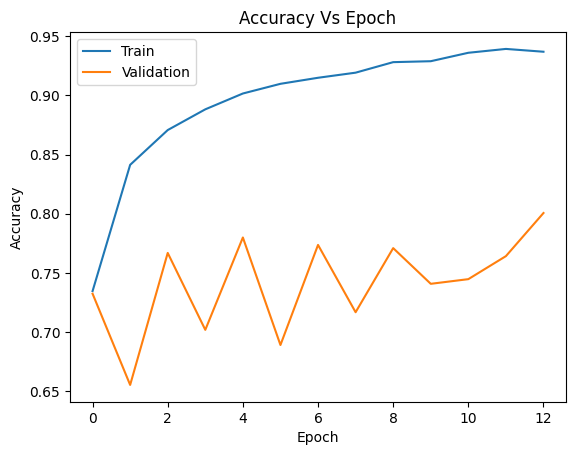

In [37]:
# Plot the training and validation accuracies
plt.plot(training_accuracies, label='Train')
plt.plot(validation_accuracies, label='Validation')
plt.title('Accuracy Vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

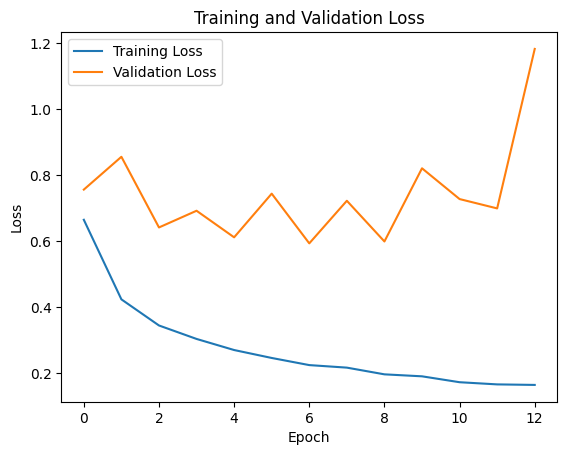

In [38]:
# Plot the training and validation losses
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

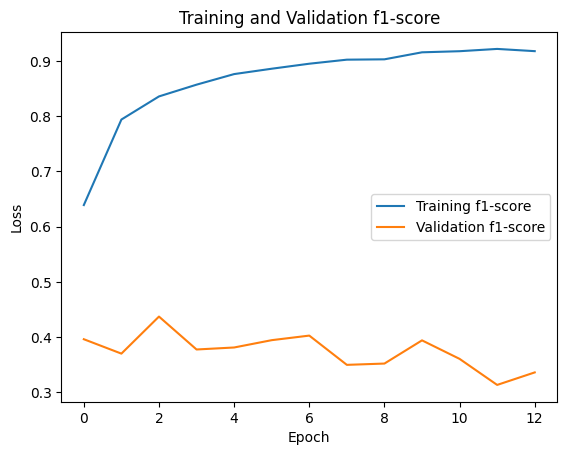

In [39]:
# Plot the training and validation losses
plt.plot(training_f1_scores, label='Training f1-score')
plt.plot(validation_f1_scores, label='Validation f1-score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation f1-score')
plt.legend()
plt.show()

In [40]:
loaded_model = CNNModel(num_classes=4).to(device)
loaded_model.load_state_dict(torch.load('best_model_pain_intesity2.pt')) 

/var/folders/jg/sz0fr37166zb_s69987d9z280000gn/T/ipykernel_53473/184455624.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('best_

<All keys matched successfully>

In [41]:
# final evaluation
val_loss, val_acc, val_prec, val_rec, val_f1_score, cf = validate(loaded_model, val_loader, 
                                                              criterion, 
                                                              device, confusion_matrix_=True)
print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation Prec: {val_prec:.4f} | Validation Rec: {val_rec:.4f} | Validation F1: {val_f1_score:.4f}")


Validation Loss: 0.6408 | Validation Acc: 0.7669 | Validation Prec: 0.4526 | Validation Rec: 0.5127 | Validation F1: 0.4371


In [42]:
class_dict = {
            'No pain': 0,
            'Low pain': 1,
            'Moderate pain': 2,
            'High pain': 3
        }


In [43]:
import seaborn as sns

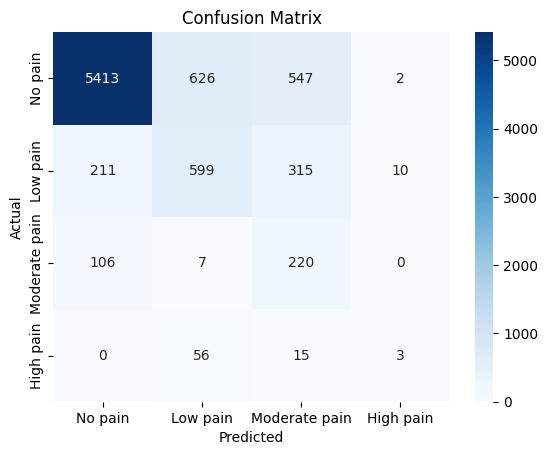

In [44]:
# Assuming class_dict is a dictionary with class names as keys
class_names = list(class_dict.keys())

cf_matrix = cf.cpu().numpy()
# Create the heatmap with class names
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
test_df['Category'].value_counts()

Category
0    2453
1     231
2     124
3     100
Name: count, dtype: int64

In [46]:

test_loss, test_acc, test_prec, test_rec, test_f1_score, cf = validate(loaded_model, test_loader, criterion, device, confusion_matrix_=True)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Prec: {test_prec:.4f} | Test Rec: {test_rec:.4f} | Test F1: {test_f1_score:.4f}")

Test Loss: 0.3480 | Test Acc: 0.8655 | Test Prec: 0.6302 | Test Rec: 0.5067 | Test F1: 0.4785


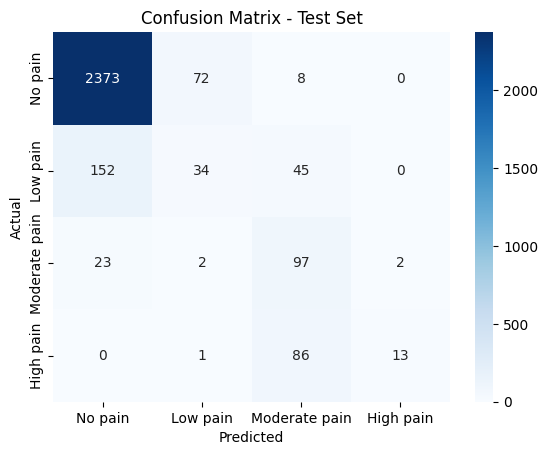

In [47]:
# Assuming class_dict is a dictionary with class names as keys
class_names = list(class_dict.keys())

cf_matrix = cf.cpu().numpy()
# Create the heatmap with class names
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()